In [1]:
##########################################################################
# Created on Sat Nov 22 16:30:45 2021                                    #
# Python for Financial Analysis and Risk Management                      #
# @author: Meng Lipeng (FRM, CFA)                                        #
##########################################################################

# 9.4.2.Cashflow of CDS

**Scenario 1(No credit event)**\
For protection buyer,
$$f_i=-\frac{s\times L}{m}\tag{9-24}$$
For protection seller,
$$f_i=\frac{s\times L}{m}\tag{9-25}$$
where,
$s$:credit spread\
$L$:notional amount\
$m$:payment frequency per year 

**Scenario 2(Credit event occured)**\
Before credit event, the same as scenario 1($i=1,2,\cdots,j-1$)\
When credit event occured at $\tilde{ t }$\
For protection buyer,
$$\tilde{ f }=-s*L*(\tilde{ t }-t_{j-1})+(1-R)\times L$$
For protection seller,
$$\tilde{ f }=s*L*(\tilde{ t }-t_{j-1})-(1-R)\times L$$
where,\
$R$:recovery rate

In [4]:
def CDS_cashflow(S,m,T1,T2,L,recovery,trader,event):
    '''Define a function to calculate CDS cashflow.
    S:credit spread
    m:payment frequency per year(no more than 2)
    T1:tenor of contract
    T2:from initial to credit event occured.'Na' indicates no credit event
    L:notional amount
    recovery:recovery rate in case of credit event.'Na' indicates no credit event
    trader:trade side.'buyer'indicates protection buyer,otherwise protection seller
    event:whether credit event occured or not.'N'indicates no credit event,other credit event occured.'''
    import numpy as np
    
    if event=='N':
        n=m*T1
        cashflow=S*L*np.ones(n)/m
    else:
        default_pay=(1-recovery)*L
        if m==1:
            n=int(T2)*m+1
            cashflow=S*L*np.ones(n)/m
            spread_end=(T2-int(T2))*S*L
            cashflow[-1]=spread_end-default_pay
        else:
            if T2-int(T2)<0.5:
                n=int(T2)*m+1
                cashflow=S*L*np.ones(n)/m
                spread_end=(T2-int(T2))*S*L
                cashflow[-1]=spread_end-default_pay
            else:
                n=(int(T2)+1)*m
                cashflow=S*L*np.ones(n)/m
                spread_end=(T2-int(T2)-0.5)*S*L
                cashflow[-1]=spread_end-default_pay
    
    if trader=='buyer':
        CF=-cashflow
    else:
        CF=cashflow
    
    return CF 

In [5]:
spread=0.012
M=1
tenor=3
par=1e8

cashflow_buyer1=CDS_cashflow(S=spread,m=M,T1=tenor,T2='Na',L=par,recovery='Na',trader='buyer',event='N')
cashflow_seller1=CDS_cashflow(S=spread,m=M,T1=tenor,T2='Na',L=par,recovery='Na',trader='seller',event='N')
print('Cashflow of protection buyer when no event occured is ',cashflow_buyer1)
print('Cashflow of protection seller when no event occured is ',cashflow_seller1)

Cashflow of protection buyer when no event occured is  [-1200000. -1200000. -1200000.]
Cashflow of protection seller when no event occured is  [1200000. 1200000. 1200000.]


In [6]:
T_default=28/12
rate=0.35
cashflow_buyer2=CDS_cashflow(S=spread,m=M,T1=tenor,T2=T_default,L=par,recovery=rate,trader='buyer',event='Y')
cashflow_seller2=CDS_cashflow(S=spread,m=M,T1=tenor,T2=T_default,L=par,recovery=rate,trader='seller',event='Y')
print('Cashflow of protection buyer when event occured is ',cashflow_buyer2)
print('Cashflow of protection seller when event occured is ',cashflow_seller2)

Cashflow of protection buyer when event occured is  [-1200000. -1200000. 64600000.]
Cashflow of protection seller when event occured is  [  1200000.   1200000. -64600000.]


In [7]:
M_new=2
T_default_new=32/12

cashflow_buyer3=CDS_cashflow(S=spread,m=M_new,T1=tenor,T2=T_default_new,L=par,recovery=rate,trader='buyer',event='Y')
cashflow_seller3=CDS_cashflow(S=spread,m=M_new,T1=tenor,T2=T_default_new,L=par,recovery=rate,trader='seller',event='Y')
print('Cashflow of protection buyer when event occured is ',cashflow_buyer3)
print('Cashflow of protection seller when event occured is ',cashflow_seller3)

Cashflow of protection buyer when event occured is  [ -600000.  -600000.  -600000.  -600000.  -600000. 64800000.]
Cashflow of protection seller when event occured is  [   600000.    600000.    600000.    600000.    600000. -64800000.]


# 9.4.3.Default probability and survival rate

**Cumulative Default Probability in [0,$t_i$] interval**
$$C_i=1-e^{-\lambda t_i}\tag{9-26}$$
where,\
$\lambda$:annualized default probabiltiy(continuous compound),also called 'hazard rate' or 'default density'\
**Survival Rate in [0,$t_i$] interval**
$$S_i=1-C_i=e^{-\lambda t_i}\tag{9-27}$$
**Marginal default probability(No default before $t_{i-1}$ but default in [$t_{i-1}$,$t_i$]interval)**
$$D_i=S_{i-1}-S_i=e^{-\lambda t_{i-1}}-e^{-\lambda t_i}\tag{9-28}$$
$D_i$ also be called 'unconditional default probability'

In [9]:
import numpy as np

h=0.03 #hazard rate
T=5
CDP=np.ones(T)

for t in range(1,T+1):
    CDP[t-1]=1-np.exp(-h*t)
CDP.round(4)

array([0.0296, 0.0582, 0.0861, 0.1131, 0.1393])

In [10]:
SR=1-CDP
SR.round(4)

array([0.9704, 0.9418, 0.9139, 0.8869, 0.8607])

In [11]:
MDP=np.ones_like(CDP)
MDP[0]=CDP[0]
for t in range(1,T):
    MDP[t]=SR[t-1]-SR[t]
MDP.round(4)

array([0.0296, 0.0287, 0.0278, 0.027 , 0.0262])

# 9.4.4.CDS spread

### 1.Mathematical expression

**PV for protection buyer**
$$PV=\frac{s}{m}L\sum_{i=1}^N S_ie^{-y_i t_i}=\frac{s}{m}L\sum_{i=1}^N e^{-(\lambda+y_i)t_i}\tag{9-29}$$
**PV for protection seller**
$$PV=(1-R)L\sum_{i=1}^N D_ie^{-y_i t_i}=(1-R)L\sum_{i=1}^N (e^{-\lambda t_{i-1}}-e^{-\lambda t_i})e^{-y_i t_i}\tag{9-30}$$
Based on no arbitrage principle,(9-29) should be equal to (9-30), we can get
$$s=m(1-R)\left[\frac{\sum_{i=1}^N e^{-\lambda t_{i-1}-y_i t_i}} {\sum_{i=1}^N e^{-(\lambda+y_i)t_i}}-1\right]\tag{9-31}$$

### 2.Implementation

In [15]:
def CDS_spread(m,Lambda,T,R,y):
    '''Define a function to calculate CDS spread.
    m:payment frequency per year
    Lambda:hazard rate
    T:tenor of contract
    R:recovery rate
    y:zero rate(continuous compound),input as array'''
    from numpy import arange,exp
    t_list=arange(m*T+1)/m
    A=sum(exp(-Lambda*t_list[:-1]-y*t_list[1:]))
    B=sum(exp(-(Lambda+y)*t_list[1:]))
    spread=m*(1-R)*(A/B-1)
    return spread

### 3.Case study

In [16]:
zero_rate=np.array([0.021276,0.022853,0.024036,0.025010,0.025976])

recovery=0.4
M=1
tenor=5
h=0.03

spread=CDS_spread(m=M,Lambda=h,T=tenor,R=recovery,y=zero_rate)
print('CDS spread is ',round(spread,4))

CDS spread is  0.0183


### 4.Sensitivity analysis

/home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/custom_python/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


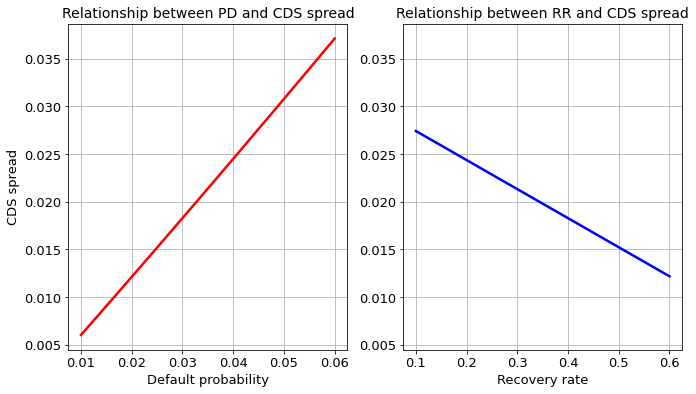

In [19]:
h_list=np.linspace(0.01,0.06,200)
spread_list1=np.zeros_like(h_list)
for i in range(len(h_list)):
    spread_list1[i]=CDS_spread(m=M,Lambda=h_list[i],T=tenor,R=recovery,y=zero_rate)
    
r_list=np.linspace(0.1,0.6,200) #recovery rate
spread_list2=np.zeros_like(r_list)
for i in range(len(r_list)):
    spread_list2[i]=CDS_spread(m=M,Lambda=h,T=tenor,R=r_list[i],y=zero_rate)
    
import matplotlib.pyplot as plt

plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
plt.plot(h_list,spread_list1,'r-',lw=2.5)
plt.xticks(fontsize=13)
plt.xlabel('Default probability',fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('CDS spread',fontsize=13)
plt.title('Relationship between PD and CDS spread',fontsize=14)
plt.grid()

plt.subplot(1,2,2,sharey=plt.subplot(1,2,1))
plt.plot(r_list,spread_list2,'b-',lw=2.5)
plt.xticks(fontsize=13)
plt.xlabel('Recovery rate',fontsize=13)
plt.yticks(fontsize=13)
plt.title('Relationship between RR and CDS spread',fontsize=14)
plt.grid()
plt.show()